In [1]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [5]:
db.list_collection_names()

['submission', 'first_and_last', 'comment']

In [6]:
# count number of documents per collection
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    952
comment       : 230853


## Build an NMF

In [7]:
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [8]:
# comms is about 100 MB in RAM
comms = pd.DataFrame(docs)

In [9]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230853 entries, 0 to 230852
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57434 non-null   object 
 3   author_flair_text                58619 non-null   object 
 4   author_fullname                  201891 non-null  object 
 5   body                             230853 non-null  object 
 6   controversiality                 230219 non-null  float64
 7   created_utc                      230853 non-null  float64
 8   distinguished                    380 non-null     object 
 9   gilded                           230215 non-null  float64
 10  id                               230853 non-null  object 
 11  link_id                          230853 non-null  object 
 12  ne

In [10]:
stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [11]:
def nlp_pre_proc_doc(input_string):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
    le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
    return ' '.join(le_s_f_lo_tokens)

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [13]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

In [14]:
n_samples = len(corpus)
n_features = 5000
n_topics = 15
n_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [15]:
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time.time() - t0))

done in 2.563s.


In [16]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5, ).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model with tf-idf features, n_samples=230853 and n_features=5000...
done in 25.069s.

Topics in NMF model:
Topic #0:
delet comment post account mod app thread file facebook reddit
Topic #1:
thank man chanc dude lot opportun plea enter generos mate
Topic #2:
peopl time make think realli use thing guy year work
Topic #3:
op ty thx thank cheer happi nm enter best birthday
Topic #4:
remov post submiss plea rule comment question regard mod thread
Topic #5:
good luck everyon enter brother pcmr job guy news veri
Topic #6:
fuck shit guy holi yeah oh stupid god polic hate
Topic #7:
giveaway great enter win thank cool hey ty gener hope
Topic #8:
look great forward cat cool amaz pretti pictur dog face
Topic #9:
im sure na gon pretti sorri glad guess gum surpris
Topic #10:
love id dog play cat copi ta absolut beauti god
Topic #11:
game play win steam want pc happi buy fun anniversari
Topic #12:
nice veri man tri realli wow work job idea thing
Topic #13:
awesom man wow dude pretti j

## Train classifier(s)

In [17]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### random forest
Spoke with Dan. He suggests using a random forest classifier on the tfidf vectors first to see the individual words that associate with the labels. Cool

need to add the class labels to the comment dataframe, k
do I have the author information from praw-only comments? 
If so, compare with set of troll author names

In [18]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
num_troll_comments = np.sum(comms['troll?'])
num_troll_comments

6704

Next, do a train test split

In [19]:
X = tfidf.toarray()
# y = comms['troll?']
y = np.array([1] * num_troll_comments + [0] * (len(X) - num_troll_comments))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30, shuffle=True)

In [21]:
# ease demand on memory...
corpus = None
X = None
docs = None
comms = None

In [22]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [23]:
rf = RandomForestClassifier(**model_param)
rf.fit(X_train, y_train)

#maxdepth...
#njobs=-1
# try fewer features per split sqrt(n)
# 100 trees ok

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=30, verbose=0,
                       warm_start=False)

In [24]:
# include the model for comparisons
clfs['Random_Forest (RF)'] = rf

In [25]:
# measure accuracy
print("\n R^2 score:", rf.score(X_test, y_test))
print(f'\n Out of bag score: {rf.oob_score_}')


 R^2 score: 0.9710857464642308

 Out of bag score: 0.9709284066665945


# 97.1% out of the box? Difficult to believe...

In [26]:
train_frac = np.sum(y_train)/len(y_train)
test_frac = np.sum(y_test)/len(y_test)
print(f'troll fraction (train): {train_frac:2.4f}')
print(f'troll fraction (test): {test_frac:2.4f}')

troll fraction (train): 0.0291
troll fraction (test): 0.0289


## right, this is an imbalanced dataset. We can get 97% accuracy just labeling everything 'not a troll'

#### Are we calling any of the documents from a troll? ... Nope!

In [27]:
y_predict = rf.predict(X_test)
np.sum(y_predict)

0

#### So precision and recall will both be zero

In [28]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.0
    recall: 0.0


/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Total accuracy is not informative here since we have such imbalanced classes. Note precision and recall are _zero_ with default settings.

#### look at the probabilities with an ROC

In [29]:
def plot_roc(X, y, clf_class, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        #clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s fold %d (area = %0.2f)' % (plot_name, i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

#### Adapt the g112_solutions `plot_roc` function to visualize the roc of our model

<ipython-input-29-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


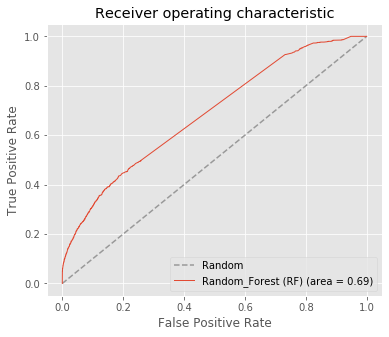

In [30]:
# rnd_smp = np.random.random_sample(len(X)) < 0.
fig, ax = plt.subplots(1, figsize=(6, 5))
#classifier_labels = ['Random_Forest (RF)', 'Balanced_RF']
#classifiers = {'Random_Forest (RF)': rf, 'Balanced_RF': brf}
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

#### what if we [account for imbalanced nature of the data](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py)?

In [31]:
brf = BalancedRandomForestClassifier(**model_param)
brf.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [32]:
# include the model for comparisons
clfs['Balanced_RF'] = brf

In [33]:
# measure accuracy
print("\n R^2 score:", brf.score(X_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(X_test)
np.sum(y_predict)


 R^2 score: 0.7609971627211887

 Out of bag score: 0.6250965314404956


11084

In [34]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.06243233489714904
    recall: 0.5183520599250936


<ipython-input-29-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-29-d9476ec26323>:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


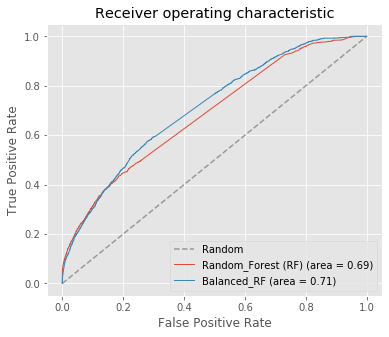

In [35]:
fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

# -- do not modify above --

In [49]:
# get code working on small dataset
downsample_mask = np.random.random_sample(len(X_train)) < 0.1
mini_X_train, mini_y_train = X_train[downsample_mask], y_train[downsample_mask]
mini_X_train.shape, mini_y_train.shape

((18492, 5000), (18492,))

In [38]:
def plot_roc(X, y, clf_class, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
#         clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

17. Use the included `plot_roc` function to visualize the roc curve of each model


/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_fore

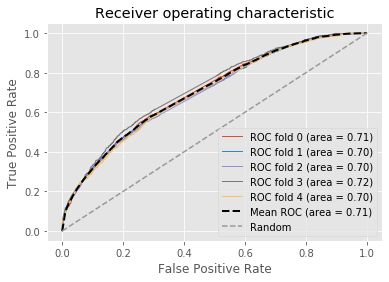

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_fore

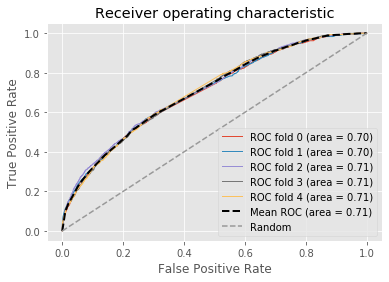

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
<ipython-input-38-66d62485b64e>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_fore

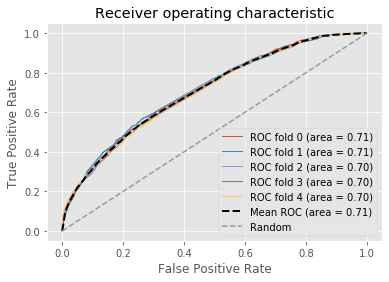

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# see `class_weight` parameter to treat unbalanced classes
# https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7
model_param = {'n_estimators': 400,
#                    'max_depth': 5,
#                    'max_features': 25,
#                    'oob_score': True,
#                    'n_jobs': -1,
                   'random_state': 30,
#                    'class_weight': 'balanced_subsample'
              }

# mini_X_train.shape, mini_y_train.shape

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', 
                            max_depth=5, max_features=25, **model_param)
gdbr = GradientBoostingClassifier(learning_rate=0.1, loss='ls', max_depth=5, 
                                 max_features=25, **model_param)
abr = AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1,
                                 **model_param)

print("17. Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X_train, y_train, rf, 'RandomForest')
plot_roc(X_train, y_train, gdbr, 'GradientBoosting')
plot_roc(X_train, y_train, abr, 'AdaBoost')


0.02907159333340552

## model inspection

#### which features are important?
